In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
plt.rc('font', family='NanumGothic')
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [9]:
df_train = df_train.drop('ID', axis=1)
df_test = df_test.drop('ID', axis=1)

In [10]:
df_train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


In [5]:
df_train.duplicated().value_counts()

False    30200
dtype: int64

In [8]:
df_train.isna().sum()

ID         0
가입일        0
음성사서함이용    0
주간통화시간     0
주간통화횟수     0
주간통화요금     0
저녁통화시간     0
저녁통화횟수     0
저녁통화요금     0
밤통화시간      0
밤통화횟수      0
밤통화요금      0
상담전화건수     0
전화해지여부     0
dtype: int64

- 가입일 : 서비스에 가입한 일수
- 음성사서함이용 : 음성사서함 이용 건수
- 주간통화시간 : 8시 ~ 16시까지의 통화 시간
- 주간통화횟수 : 8시 ~ 16시까지의 통화 횟수
- 주간통화요금 : 8시 ~ 16시까지의 통화 요금
- 저녁통화시간 : 16시 ~ 0시까지의 통화 시간
- 저녁통화횟수 : 16시 ~ 0시까지의 통화 횟수
- 저녁통화요금 : 16시 ~ 0시까지의 통화 요금
- 밤통화시간 : 0시 ~ 8시까지의 통화 시간
- 밤통화횟수 : 0시 ~ 8시까지의 통화 횟수
- 밤통화요금 : 0시 ~ 8시까지의 통화 요금
- 상담전화건수 : 고객센터에 전화를 건 횟수
- 전화해지여부 : 0(서비스 유지)/ 1(서비스 해지)

- 가입일이 길수록 서비스를 유지하는 고객이 많을 것
- 상담전화건수가 적을수록 서비스를 유지하는 고객이 많을 것
- 주간, 저녁, 밤 통화시간에 따라서 해지여부가 달라지는지

### Base Model

In [69]:
X, y = df_train.iloc[:, :-1], df_train['전화해지여부']

def train_eval(X, y, model, model_param):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

#     cv = KFold(n_splits=2)
#     grid_model = GridSearchCV(estimator=model,
#                               param_grid=model_param,
#                               scoring='neg_mean_squared_error'
#                              )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print('RMSE :', rmse)

### 기본 정보 확인

In [11]:
df_train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


가입일과 음성사서함이용 feature의 왜도가 매우 클 것으로 보임 -> 이상치 처리 필요

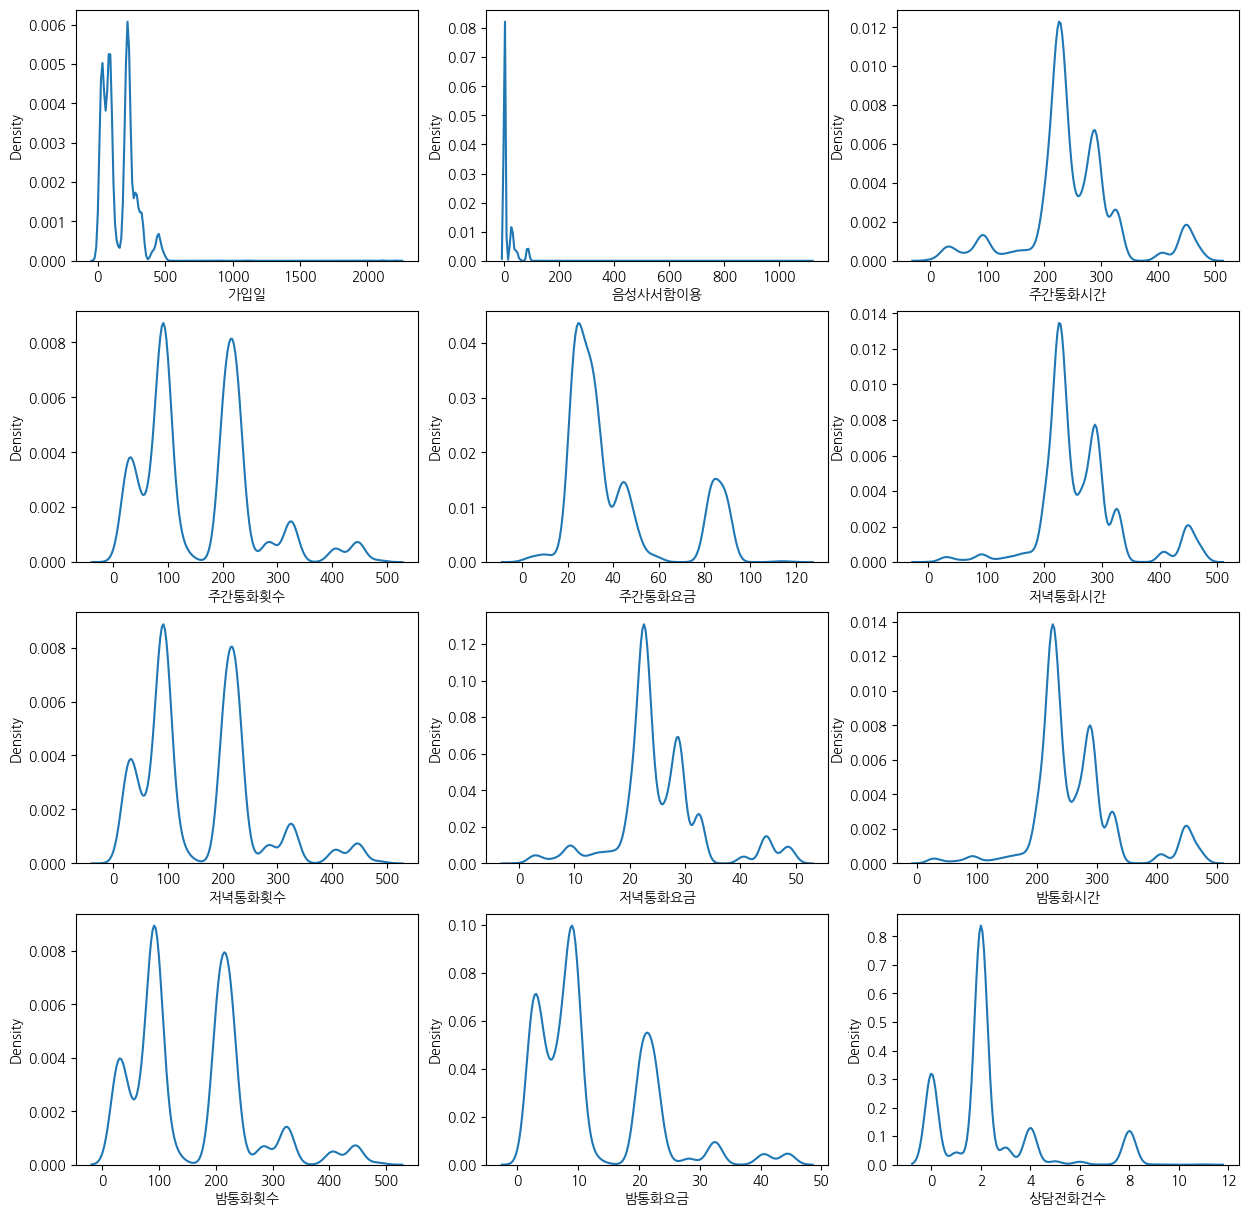

In [22]:
plt.figure(figsize=(15,15))
for i in range(1,13):
    plt.subplot(4,3,i)
    sns.kdeplot(data=df_train, x=df_train.columns[i-1])

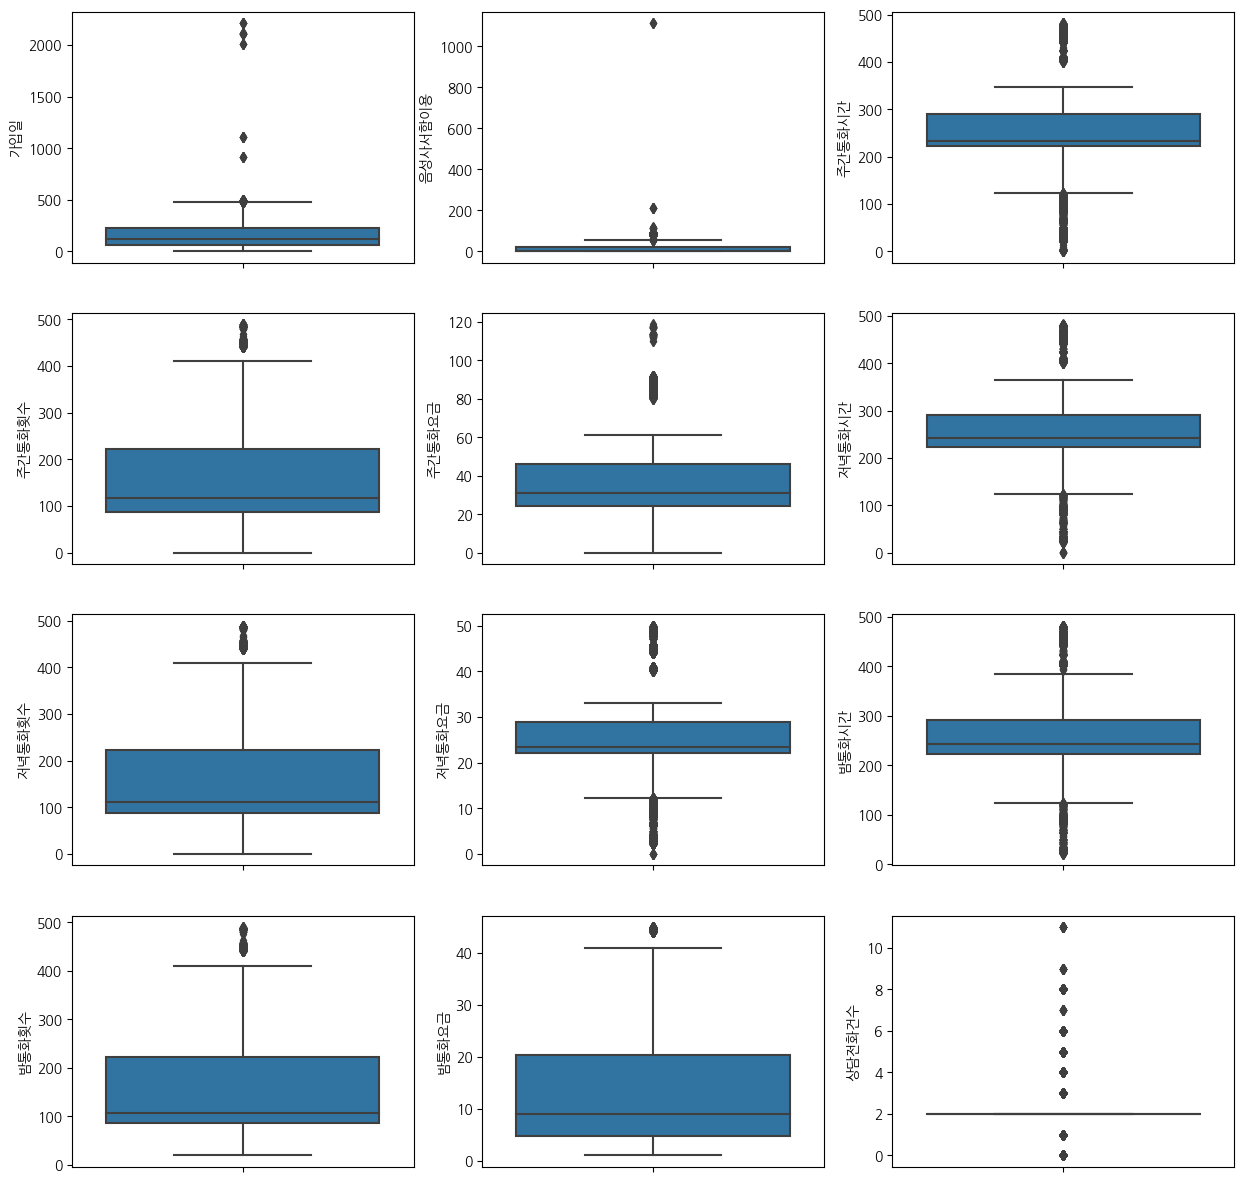

In [23]:
plt.figure(figsize=(15,15))
for i in range(1,13):
    plt.subplot(4,3,i)
    sns.boxplot(data=df_train, y=df_train.columns[i-1])

In [24]:
for i in range(13):
    print('#', df_train.columns[i], end=' : ')
    print(df_train.iloc[:,i].skew())

# 가입일 : 3.1067042261244944
# 음성사서함이용 : 10.159493995261448
# 주간통화시간 : 0.177855504849492
# 주간통화횟수 : 0.7660394283278664
# 주간통화요금 : 1.193922253784196
# 저녁통화시간 : 0.7681298248414079
# 저녁통화횟수 : 0.8011344995628895
# 저녁통화요금 : 0.5928134319598141
# 밤통화시간 : 0.7825451243176796
# 밤통화횟수 : 0.8083958481002662
# 밤통화요금 : 1.2761947161273253
# 상담전화건수 : 1.5545618208265488
# 전화해지여부 : 2.495178425177844


음성사서함은 이용하지 않는 사람이 대부분

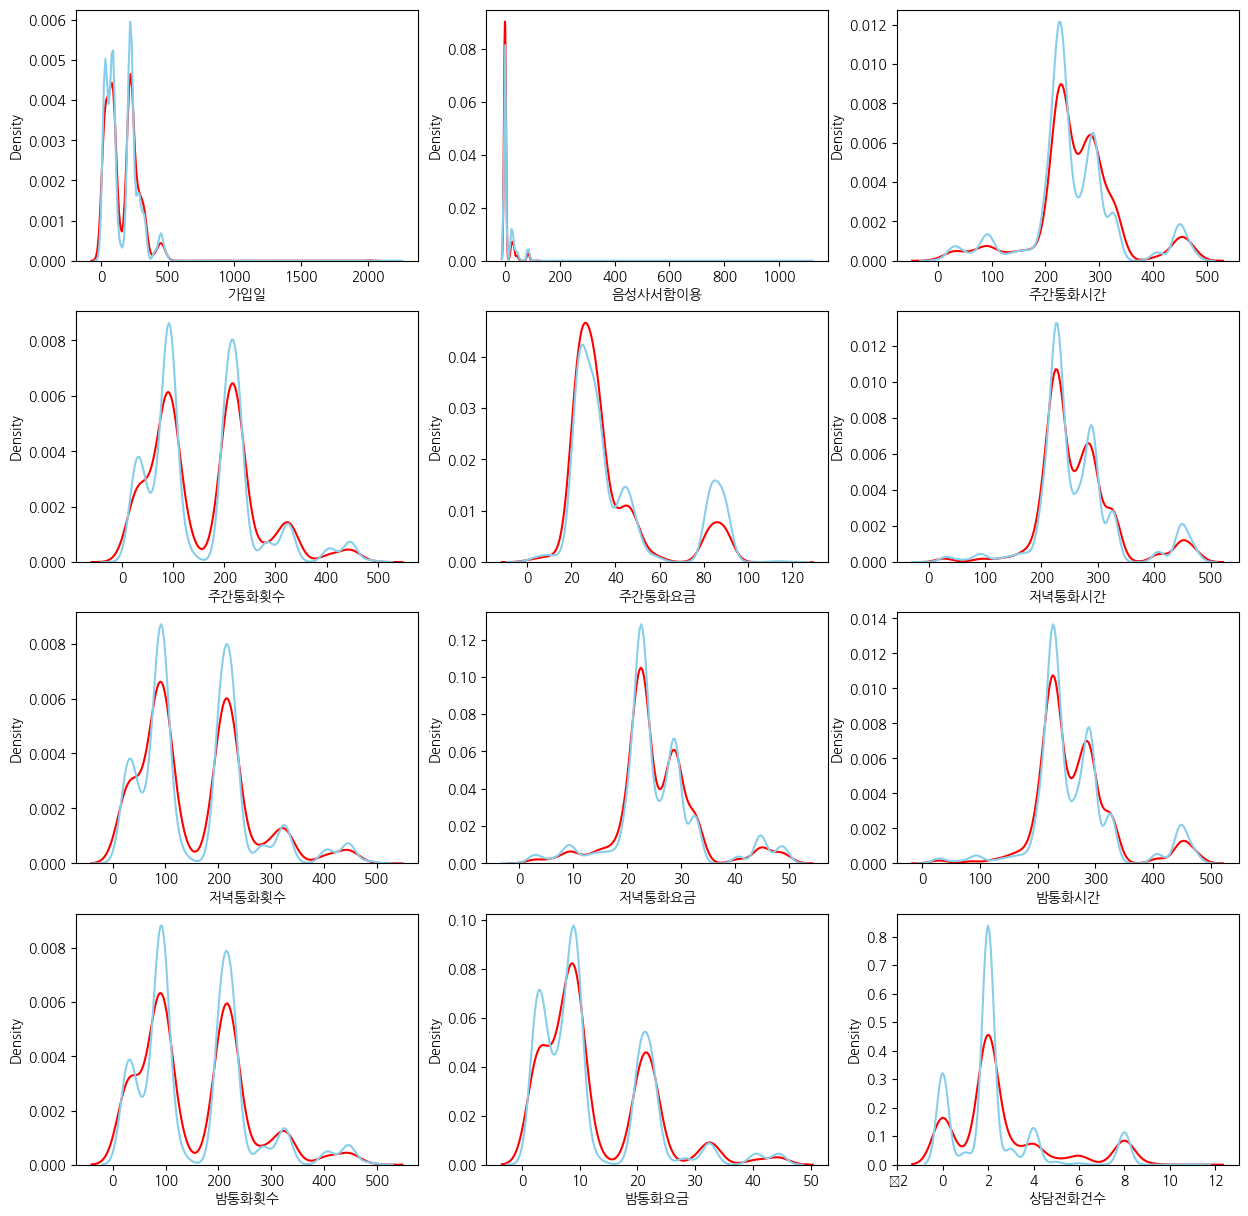

In [31]:
plt.figure(figsize=(15,15))
for i in range(1,13):
    plt.subplot(4,3,i)
    sns.kdeplot(data=df_train[df_train.전화해지여부==1], x=df_train.columns[i-1], color='red')
    sns.kdeplot(data=df_train[df_train.전화해지여부==0], x=df_train.columns[i-1], color='skyblue')

<AxesSubplot:>

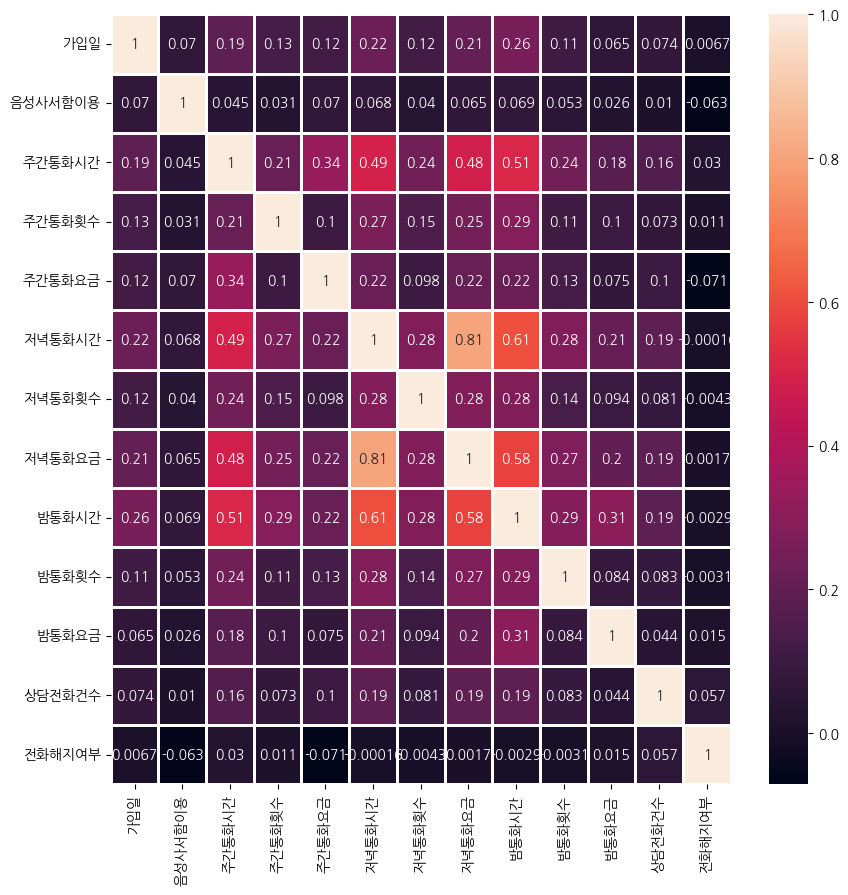

In [34]:
plt.figure(figsize=(10,10))

corr = df_train.corr()
sns.heatmap(corr, annot=True, linewidth=1)

### 가입일이 길어질수록 서비스를 유지하는 사람이 많을 것이다

<AxesSubplot:xlabel='가입일', ylabel='Density'>

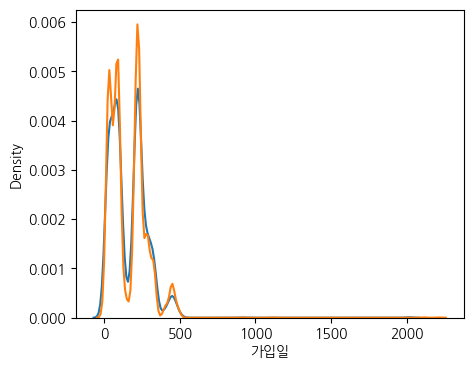

In [39]:
plt.figure(figsize=(5,4))
sns.kdeplot(data=df_train[df_train['전화해지여부']==1], x='가입일')
sns.kdeplot(data=df_train[df_train['전화해지여부']==0], x='가입일')

<AxesSubplot:xlabel='가입일', ylabel='Density'>

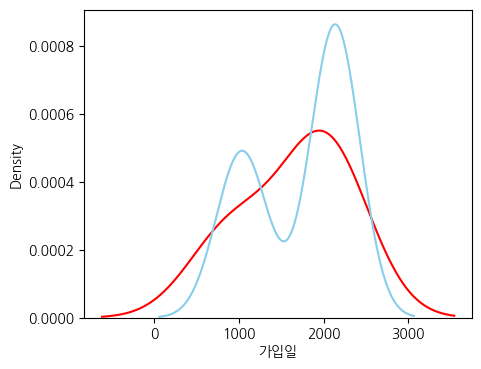

In [49]:
plt.figure(figsize=(5,4))
df_cont = df_train[df_train['가입일']>500]
sns.kdeplot(data=df_cont[df_cont['전화해지여부']==1], x='가입일', color='red')
sns.kdeplot(data=df_cont[df_cont['전화해지여부']==0], x='가입일', color='skyblue')

가입일이 500일 이상인 경우에 대해서 새로운 feature 생성

In [71]:
df_train['가입일500up'] = np.where(df_train['가입일']>=500, 1, 0)
df_test['가입일500up'] = np.where(df_test['가입일']>=500, 1, 0)

### 주간/저녁/밤 통화시간과 통화횟수가 상식적으로 일치하는지 확인

1. 주간

In [54]:
df_train[df_train.주간통화시간==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap
5512,203,1,0.0,0,0.4,292.8,230,26.33,264.5,93,2.6,2,0,0,203


In [55]:
df_train[df_train.주간통화횟수==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap
1181,93,1,0.6,0,1.6,241.1,230,23.32,263.4,34,2.32,2,1,0,93
5512,203,1,0.0,0,0.4,292.8,230,26.33,264.5,93,2.60,2,0,0,203
8227,203,0,0.5,0,0.0,292.4,229,26.88,270.5,99,2.60,2,0,0,203
9736,99,1,1.8,0,0.1,291.2,281,28.82,262.9,89,2.82,2,1,0,99
11111,203,1,0.3,0,1.0,293.1,229,26.88,269.8,98,2.60,2,0,0,203
14268,101,0,1.9,0,1.4,193.9,120,16.33,169.4,95,7.60,1,0,0,101
15877,94,1,0.1,0,2.0,241.2,230,23.32,263.3,33,2.32,2,1,0,94
18054,98,1,1.1,0,0.7,291.1,280,28.82,263.0,89,2.82,2,1,0,98


주간통화횟수가 0인데 주간통화시간이 0 이상 -> 주간통화횟수를 1로 치환

In [56]:
df_train.loc[df_train.주간통화횟수==0, '주간통화횟수'] = 1

2. 저녁

In [57]:
df_train[df_train.저녁통화시간==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap


In [58]:
df_train[df_train.저녁통화횟수==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap
2671,92,1,210.4,232,34.2,0.3,0,0.0,224.9,92,2.39,2,0,0,92
14539,92,1,210.7,283,90.2,0.2,0,0.0,329.8,92,2.89,2,0,0,92
22933,97,1,411.4,455,56.4,0.5,0,0.0,476.7,95,7.89,4,0,0,97
23169,92,0,209.4,242,46.0,1.2,0,0.0,225.8,93,2.49,2,0,0,92
24794,93,0,210.5,243,45.2,1.3,0,0.0,225.1,93,2.49,2,0,0,93


In [59]:
df_train.loc[df_train.저녁통화횟수==0, '저녁통화횟수'] = 1

3. 밤

In [61]:
df_train[df_train.밤통화시간==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap


In [62]:
df_train[df_train.밤통화횟수==0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap


### 가입일, 음성사서함이용 이상치 처리

In [65]:
q1 = np.percentile(df_train.가입일, 25)
q3 = np.percentile(df_train.가입일, 75)
print('가입일')
print(q1)
print(q3)

가입일
63.0
228.0


In [66]:
q1 = np.percentile(df_train.음성사서함이용, 25)
q3 = np.percentile(df_train.음성사서함이용, 75)
print('음성사서함이용')
print(q1)
print(q3)

음성사서함이용
0.0
22.0


In [67]:
df_train.loc[df_train.가입일<63.0, '가입일'] = 63.0
df_train.loc[df_train.가입일>228.0, '가입일'] = 228.0
df_test.loc[df_test.가입일<63.0, '가입일'] = 63.0
df_test.loc[df_test.가입일>228.0, '가입일'] = 228.0

In [68]:
df_train.loc[df_train.음성사서함이용<0.0, '음성사서함이용'] = 0.0
df_train.loc[df_train.음성사서함이용>22.0, '음성사서함이용'] = 22.0
df_test.loc[df_test.음성사서함이용<0.0, '음성사서함이용'] = 0.0
df_test.loc[df_test.음성사서함이용>22.0, '음성사서함이용'] = 22.0

In [70]:
df_train

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입일500up,가입일500cap
0,228,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0,0,329
1,63,22,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0,0,2
2,93,22,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0,0,93
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0,0,223
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0,0,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30195,228,22,289.6,201,21.8,280.5,323,29.88,208.0,66,9.28,2,0,0,263
30196,228,22,210.7,280,90.5,284.1,202,32.80,287.8,203,6.28,2,0,0,283
30197,63,0,222.4,33,22.1,233.9,32,22.22,293.6,95,4.22,2,0,0,24
30198,63,1,262.4,202,29.6,280.6,282,28.88,280.9,207,20.88,2,1,0,63


boxplot 확인 -> 이상치 모두 처리 완료

<AxesSubplot:ylabel='가입일'>

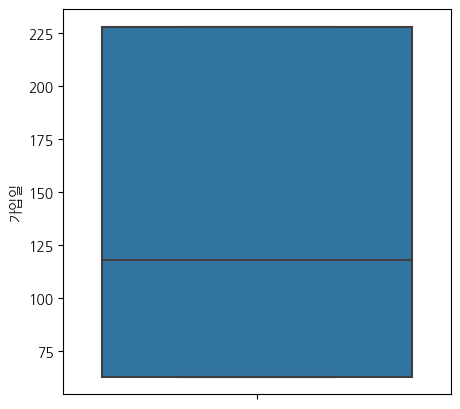

In [92]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df_train, y='가입일')

<AxesSubplot:ylabel='음성사서함이용'>

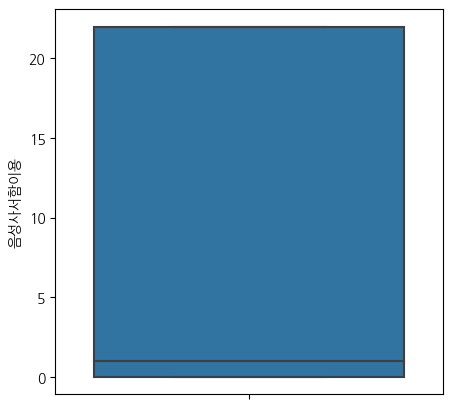

In [93]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df_train, y='음성사서함이용')

### 통화시간 * 통화횟수 feature 생성

In [84]:
df_train['주간통화시간*횟수'] = df_train['주간통화시간'] * df_train['주간통화횟수']
df_test['주간통화시간*횟수'] = df_test['주간통화시간'] * df_test['주간통화횟수']

df_train['저녁통화시간*횟수'] = df_train['저녁통화시간'] * df_train['저녁통화횟수']
df_test['저녁통화시간*횟수'] = df_test['저녁통화시간'] * df_test['저녁통화횟수']

df_train['밤통화시간*횟수'] = df_train['밤통화시간'] * df_train['밤통화횟수']
df_test['밤통화시간*횟수'] = df_test['밤통화시간'] * df_test['밤통화횟수']

### corr 재확인
가입일, 음성사서함이용 feature의 correlation이 소폭 상승

<AxesSubplot:>

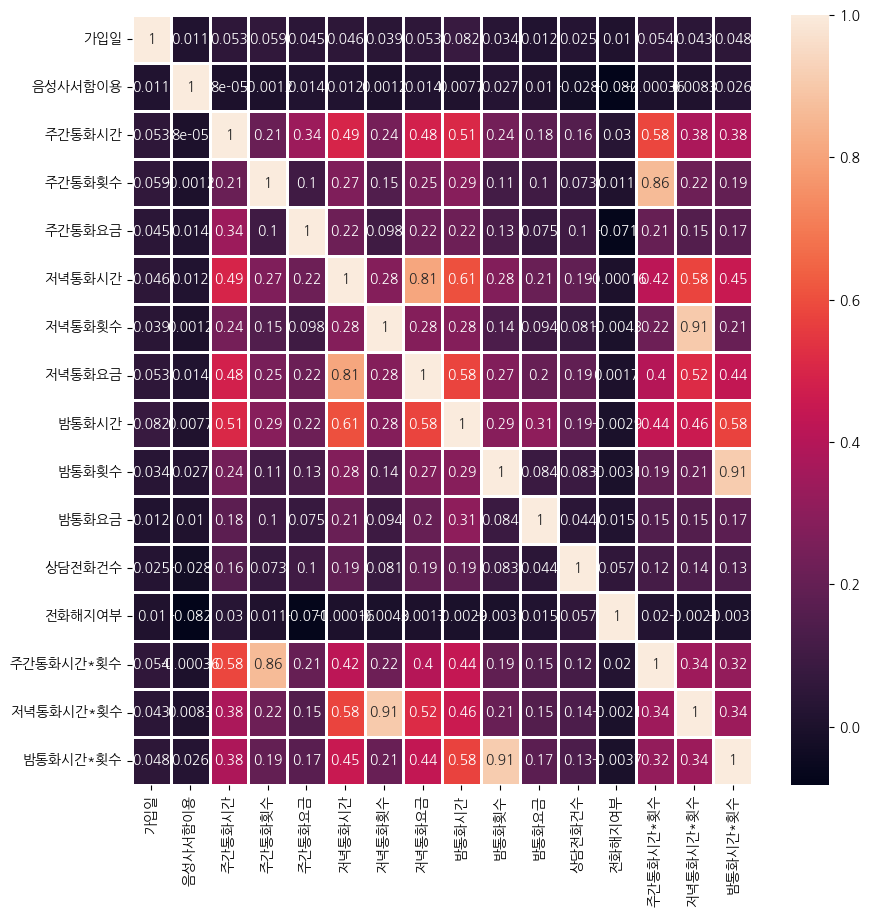

In [94]:
plt.figure(figsize=(10,10))

corr = df_train.corr()
sns.heatmap(corr, annot=True, linewidth=1)

### Modeling

In [88]:
df_train

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,주간통화시간*횟수,저녁통화시간*횟수,밤통화시간*횟수
0,228,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0,9225.6,18278.4,86231.2
1,63,22,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0,104619.7,87824.4,67465.2
2,93,22,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0,91215.2,66654.0,92102.4
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0,49372.2,14213.0,47689.2
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0,21378.6,15449.1,58671.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30195,228,22,289.6,201,21.8,280.5,323,29.88,208.0,66,9.28,2,0,58209.6,90601.5,13728.0
30196,228,22,210.7,280,90.5,284.1,202,32.80,287.8,203,6.28,2,0,58996.0,57388.2,58423.4
30197,63,0,222.4,33,22.1,233.9,32,22.22,293.6,95,4.22,2,0,7339.2,7484.8,27892.0
30198,63,1,262.4,202,29.6,280.6,282,28.88,280.9,207,20.88,2,1,53004.8,79129.2,58146.3


In [97]:
model = LGBMClassifier(n_estimators=500, max_depth=5)
# model_param = param_lgbm
X, y = df_train.drop('전화해지여부', axis=1), df_train['전화해지여부']

# cv = KFold(n_splits=2)
# grid_model = GridSearchCV(estimator=model,
#                           param_grid=model_param,
#                           scoring='neg_mean_squared_error'
#                          )

model.fit(X, y)
y_pred = model.predict(df_test)

subm['전화해지여부'] = y_pred
subm.to_csv('sub2.csv', index=False)